This is a noisy trajectory, without weigths

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:90% !important;</style>"))
import os 
os.chdir("..")
%load_ext autoreload
%autoreload 2
from tqdm import tqdm
from numerics.integration.matrices import *
from numerics.utilities.misc import *
import tensorflow as tf
from numerics.machine_learning.models import * 
import matplotlib.pyplot as plt
physical_devices = tf.config.list_physical_devices('GPU') 
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)


/tmp/ipykernel_42006/3685532613.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


2022-05-17 16:10:20.323179: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-17 16:10:20.344905: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-17 16:10:20.345010: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:
params, exp_path = def_params()
xi, kappa, omega, eta = params

T = 100.
dt = 1e-3

total_time,dt = T*kappa, kappa*dt


states_si, dys_si = load(itraj=1, exp_path=exp_path, total_time=total_time, dt=dt, ext_signal=1)

times = get_time(total_time,dt).astype(np.float32)
dd = tf.unstack(dys_si.astype(np.float32),axis=1)

tfsignals = tf.stack([times[:-1],dd[0], dd[1]])
tfsignals = tf.transpose(tfsignals)[tf.newaxis]

2022-05-17 16:10:20.376147: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-17 16:10:20.376955: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-17 16:10:20.377074: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-17 16:10:20.377148: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

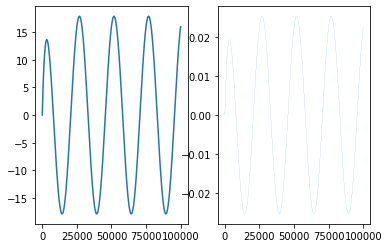

In [9]:
plt.subplot(121)
plt.plot(states_si[:,0])
plt.subplot(122)
plt.plot(tfsignals[0][:,1], linewidth=0.1)

In [4]:
params, exp_path = def_params()

initial_parameters = np.array([10., 3.5*np.pi/total_time]).astype(np.float32)
true_parameters = np.array([10., 4*2*np.pi/total_time]).astype(np.float32)


A, D , E, B  = genoni_matrices(*params)
xicov, covss = genoni_xi_cov(A,D, E, B ,params, stat=True)

BS = 1#len(tfsignals[0])
batch_shape = [BS, None, 3]
model = Model(params=params, dt=dt, initial_parameters=initial_parameters,
              true_parameters=true_parameters, initial_states = np.zeros((1,5)).astype(np.float32),
              cov_in=covss, batch_size=tuple([None,None,3]))#tuple(batch_shape))
model.recurrent_layer.build(tf.TensorShape(batch_shape))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2))

In [6]:
spp = tf.split(tfsignals, 50, axis=1)

In [7]:
n_epochs = 10

In [8]:
cc = []
for epoch in range(n_epochs):
    model.reset_states()  
    for k in spp:
        bb = model.train_step((k,k))
        cc+=[bb]
    loss =  np.squeeze(bb["LOSS"].numpy())
    print("\r EPOCH {}/{}   loss:{}    params{}    grads{}".format(epoch, n_epochs,loss, np.squeeze(bb["PARAMS"].numpy()), np.squeeze(bb["GRADS"].numpy())),end="")
    if loss<1e-10:
        break

2022-05-17 16:10:43.783747: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


 EPOCH 9/10   loss:0.06193508207798004    params[ 9.124218   -0.25412917]    grads[-0.01976766  5.8980484 ]]1]

In [15]:
def plot_history(cc, preds=None):
    plt.figure(figsize=(20,5))
    if preds is None:

        ax1 = plt.subplot(131)
        ax2 = plt.subplot(132)
        ax3 = plt.subplot(133)       
    else:
        ax1 = plt.subplot(141)
        ax2 = plt.subplot(142)
        ax3 = plt.subplot(143)       
        ax4 = plt.subplot(144)
    
    history_loss = np.squeeze([cc[k]["LOSS"] for k in range(len(cc))])
    ax1.set_title("LOSS")
    ax1.plot(history_loss)
    ax1.loglog()
    ax1.set_xlabel("GRADIENT STEP")
    
    params=np.squeeze([cc[k]["PARAMS"] for k in range(len(cc))])
    ax2.set_title("PARAMS")
    ax2.plot(params[:,0],label="RNN")
    ax2.plot(np.ones(len(params))*true_parameters[0], '--',label="true")
    ax2.set_xlabel("GRADIENT STEP")
    ax2.legend()
    
    grads = np.squeeze([cc[k]["LOSS"] for k in range(len(cc))])
    ax3.set_title("GRADS")
    ax3.plot(grads)
    ax3.loglog()
    
    
    if preds is not None:
        ax4.set_title("PREDICTIONS")
        ax4.plot(np.squeeze(preds)[:,0], '--',color="red", alpha=0.5,label="RNN")
        ax4.plot(dd[0], color="blue", label="true", alpha=0.5)
        ax4.legend()

In [19]:
freq = 4*2*np.pi/10

In [20]:

model.trainable_variables[0].assign(tf.convert_to_tensor(np.array([[10. , freq]]).astype(np.float32)))

<tf.Variable 'UnreadVariable' shape=(1, 2) dtype=float32, numpy=array([[10.       ,  2.5132742]], dtype=float32)>

In [21]:
preds = model.predict(tfsignals)

In [16]:
model.reset_states()
preds = model.predict(tfsignals)

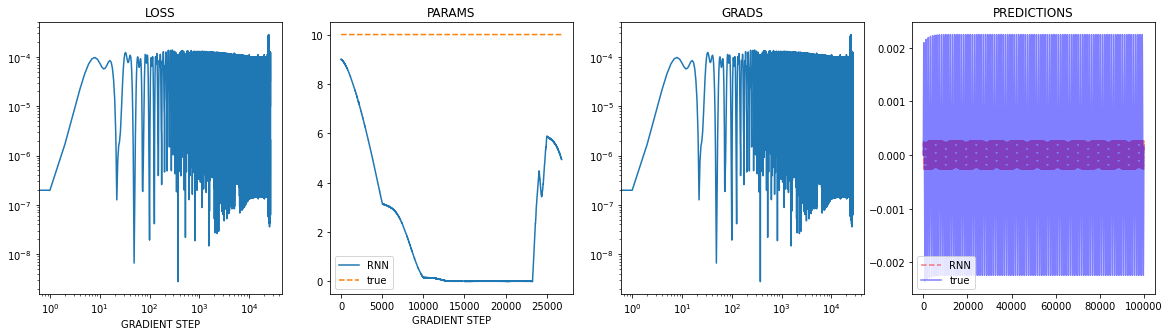

In [17]:
plot_history(cc, preds)

In [12]:
loss = [cc[k]["LOSS"].numpy() for k in range(len(cc))]
grads = np.squeeze([cc[k]["GRADS"].numpy() for k in range(len(cc))])
params = np.squeeze([cc[k]["PARAMS"].numpy() for k in range(len(cc))])